# Spin-Boson model with Structured Spectral Densities

In this example, we demonstrate how to simulate a two-level system interacting with an Ohmic environment. This model, commonly referred to as the *spin-boson* model, differs from the pure dephasing case in that the system Hamiltonian includes diabatic couplings that enable population transfer. As a result, the dynamics exhibits dissipation until the system reaches its stationary state. Moreover, these couplings generate quantum coherence that survives in the long-time dynamics.

The system Hamiltonian is given by

$$
H_S = \frac{\Delta\epsilon}{2} \sigma_z + \frac{V}{2} \sigma_x,
$$

where $\Delta\epsilon$ is the energy difference between levels and $V$ is the diabatic coupling between levels. Under these conditions, the system-bath interaction Hamiltonian takes the form

$$
H_{SB} = \frac{\sigma_z}{2} \otimes X_B,
$$

where $Q_S=\sigma_z$ and it is the system operator and

$$
X_B = \sum_j c_j x_j.
$$

The spin-boson Hamiltonian lies at the heart of open-quantum-system theory: beneath its deceptively simple form it captures an extraordinary breadth of physical phenomena. By linking quantum dissipation with its classical analogue of friction, the model has become a versatile framework that underpins research from molecular dynamics in chemical physics to contemporary problems in quantum information science.

In this case, we consider a Structured Spectral Denstity:

$$
J(\omega) = \frac{2}{\pi}\frac{\lambda\omega\omega_c}{\omega_c^2 + \omega^2}+\sum_{b=1}\frac{4}{\pi}\lambda_{b}\omega_{b}^2 \frac{\omega\gamma_{b}}{\left(\omega^2-\omega_{b}^2 \right)^2+4\omega^2\gamma_{b}^2}
$$

where $\lambda$ and $\lambda_{b}$ are the DL reorganization energy and the reorganization energy of the b-th Brownian Oscillator; $\omega_c$ and $\gamma_{b}$ are the DL cutoff frequency and the cutoff frequency of the b-th Brownian Oscillator; and $\omega_{b}$ is the resonance frequency of the b-th Brownian Oscillator. This equation could be written as

$$
J_T(\omega) = J_{DL}(\omega) + \sum_{b}J_{b}(\omega)
$$


## Setup

Once *TENSO* is installed, the necessary libraries can be imported to begin the simulations. TENSO provides an auxiliary function designed to construct the bath correlation function in a systematic and efficient way. Additionally, it includes the `spin_boson` integrator, which conveniently incorporates all system parameters, enabling the simulation of open quantum dynamics within the spin-boson framework.


In [1]:
from math import ceil
import os
import json as json
import numpy as np
from tqdm import tqdm

from tenso.prototypes.heom import spin_boson #Spin-boson helper function
from tenso.prototypes.bath import gen_bcf #Bath correlation function generator
import matplotlib.pyplot as plt

In [2]:
out = "structured_result_300K" #Output directory

## Bath Correlation Function (BCF)

The bath correlation function encodes all the essential information required to capture the influence of the environment on the reduced density matrix of the system, $\rho_S(t)$. It is defined as

$$
C(t)=\mathrm{Tr}\bigl(\tilde{X}_B(t)\,\tilde{X}_B(0)\,\rho_B^{\mathrm{eq}}\bigr),
$$

and is related to the spectral density $J(\omega)$ through

$$
C(t)=\int_{-\infty}^{\infty} \mathcal{J}(\omega)(1-e^{-\beta \omega})^{-1}e^{-i\omega t}\mathrm{d}\omega
$$

and following the structure of the spectral density the BCF could be written as

$$
C_T(t) = C_{DL}(t) + C_{\alpha}(t)
$$

TENSO provides two approaches for decomposing the bath correlation function into sums of exponentials: the Matsubara and the Padé schemes. In this example, we focus on the Padé decomposition following the $\left( N - 1 \right)/N$ scheme. In general, such decompositions take the form

$$
C(t) = \sum_{k=1}^{K} c_k e^{  \gamma_k t}\quad \mathrm{and} \quad C^*(t) = \sum_{k=1}^{K} \bar{c_k} e^{  \gamma_k t}$$

The `get_bcf` function accepts different arguments depending on the choice of spectral density and decomposition method. For a Drude-Lorentz spectral density combined with a Padé decomposition, the main parameters are:

- `re_d`: The Drude-Lorentz reorganization energy, $\lambda$. This parameter should be provided as a list.
- `width_d`: The Drude-Lorentz cutoff frequency (the width of $J(\omega)$), also specified as a list.
- `freq_b`: It denotes the resonance frequency of the vibrational mode represented in the spectral density $J(\omega)$.
- `re_b`: The Underdamped Brownian reorganization energy, $\lambda$. This parameter should be provided as a list.
- `width_b`: The Underdamped Brownian cutoff frequency (the width of $J(\omega)$), also specified as a list.

Note that parameters associated with the under-damped Brownian spectral density are labelled with the subscript `_b`, whereas those pertaining to the Drude–Lorentz form carry the subscript `_d`.

- `temperature`: The bath temperature in K (float).
- `decomposition_method`: The method used for the decomposition of the BCF (string).
- `n_ltc`: The number of low-temperature corrections.


In [3]:
bath_simulation = gen_bcf(
    re_d=[540],    #Reorganization energy in cm-1
    width_d=[70],  #Width of the DL spectral density in cm-1
    freq_b=[1243], # Central Frequency of the Brownian Spectral density in cm-1
    re_b=[161.6], #Reorganization energy of the Brownian Spectral density in cm-1
    width_b=[10],  #Width of the spectral density in cm-1
    temperature=300, #Temperature in Kelvin
    decomposition_method='Pade', #Decomposition method for the bath correlation function
    n_ltc=1, #Number of low-temperature correction terms
)
#print(bath_simulation, flush=True)

In [4]:
bath_simulation = gen_bcf(
    re_d=[540],    #DL spectral densities: reorganization energies in cm-1
    width_d=[70], #DL spectral densities:  width of spectral density in cm-1
    freq_b=[1243], # BO spectral densities: central frequencies in cm-1
    re_b=[161.6], #BO spectral densities: reorganization energy in cm-1
    width_b=[10],  #BO spectral densities: widths in cm-1
    temperature=300, #Temperature in Kelvin
    decomposition_method='Pade', #Decomposition method for the bath correlation function
    n_ltc=1, #Number of low-temperature correction terms
)


## `n_ltc` effect

To explore how the parameter `n_ltc` influences the bath correlation function, we examined a range of values. Even with an exceedingly large number of low-temperature corrections, it is evident that the real part of the correlation function exhibits noticeable changes at very short times as `n_ltc` increases. However, these variations generally occur on a very small scale that does not significantly impact the overall accuracy of the dynamics.


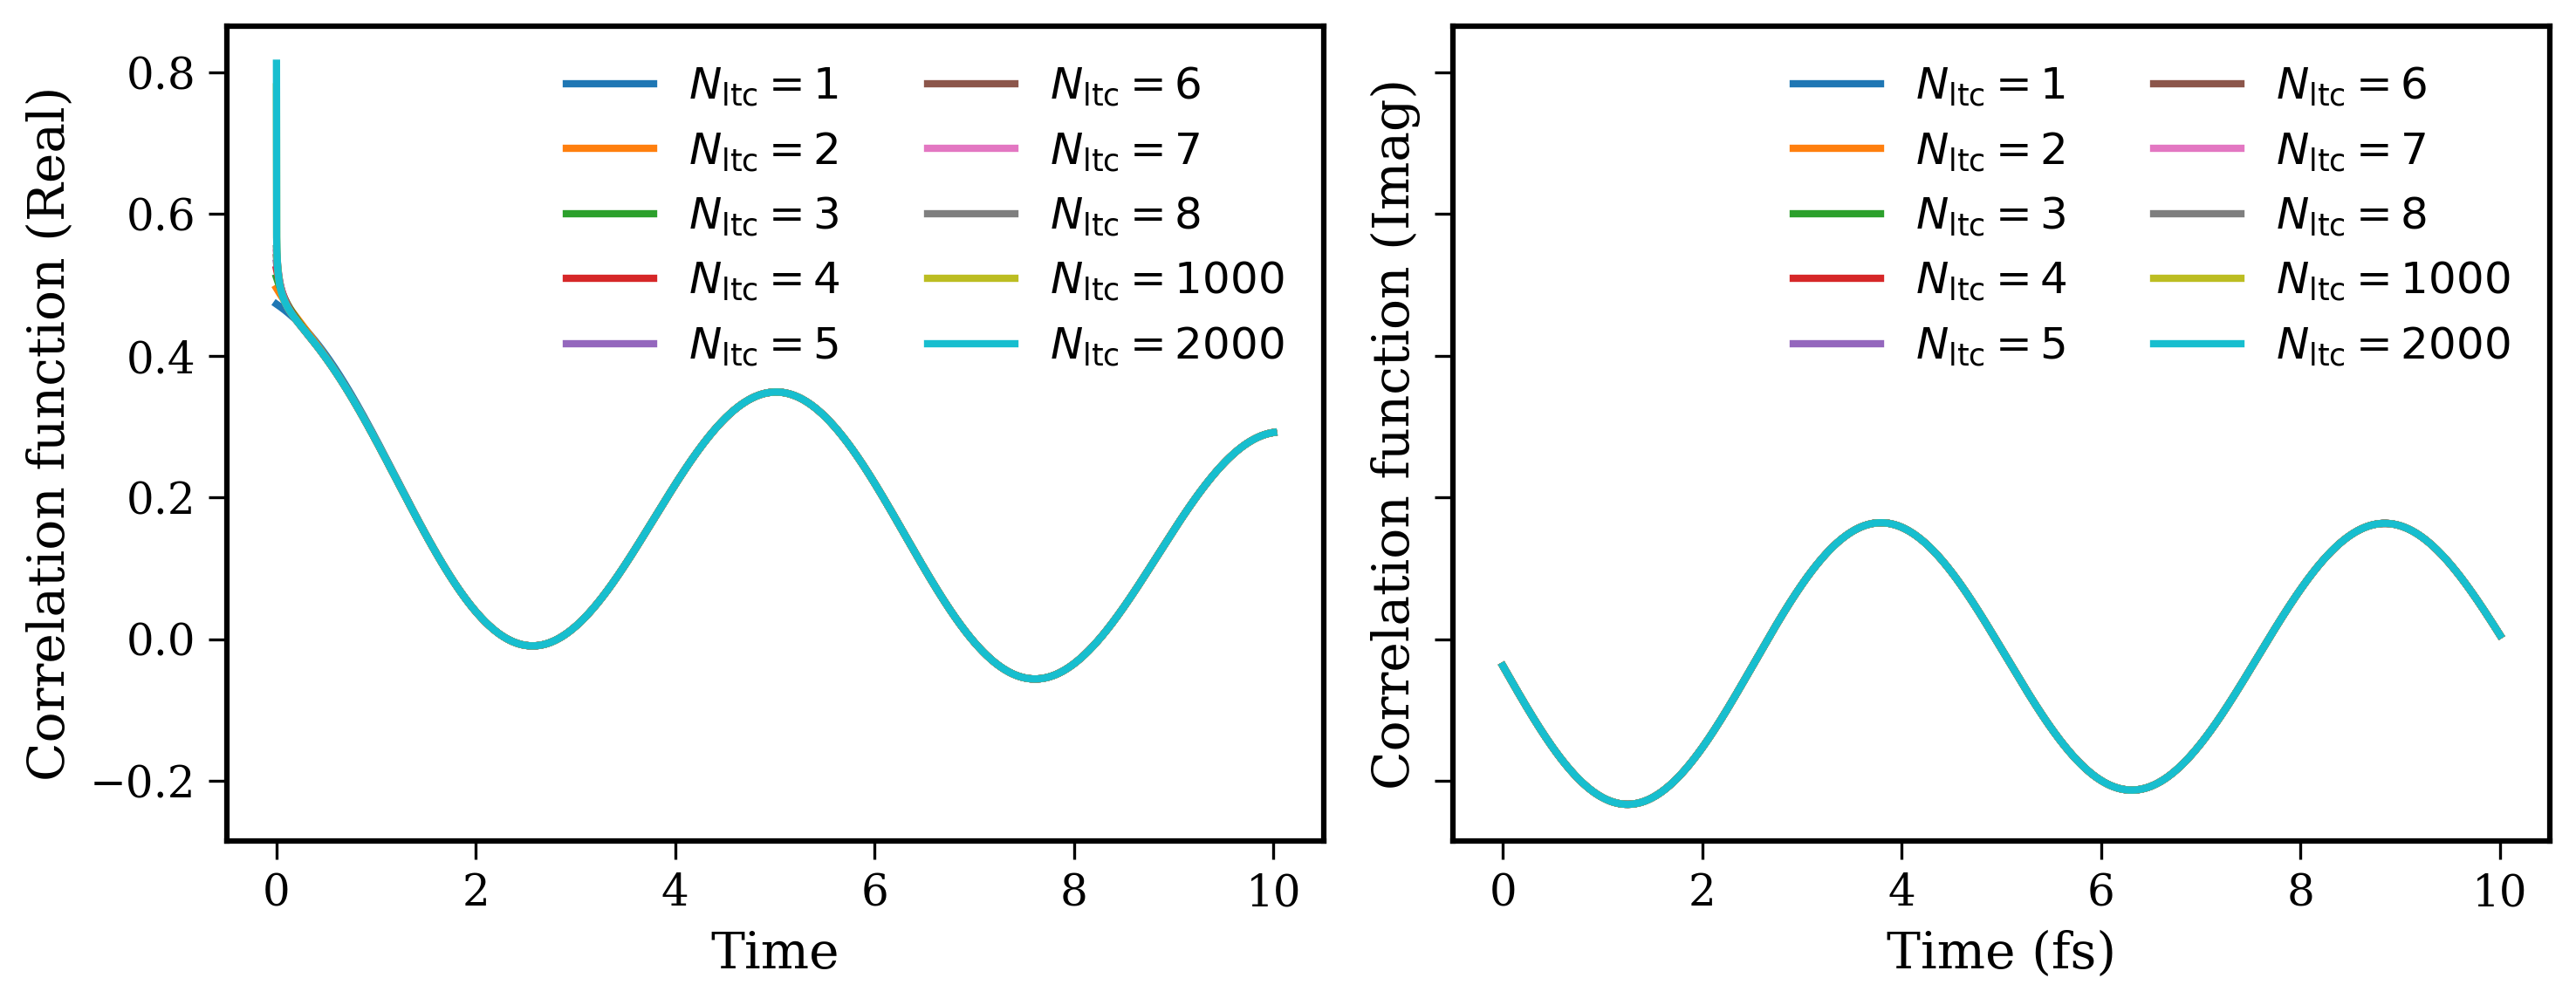

In [4]:
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'lines.linewidth': 2,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.fontsize': 12,
    'figure.dpi': 300,
})

# --- time ---
t = np.linspace(0, 10, 10000)

fig, (ax_real, ax_imag) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

def plot_bcf(n_ltc):
    bath = gen_bcf(
        re_d=[540],
        width_d=[70],
        freq_b=[1243],
        re_b=[161.6],
        width_b=[10],
        temperature=300,
        decomposition_method='Pade',
        n_ltc=n_ltc,
    )
    #print(bath, flush=True)

    ax_real.plot(t, bath.real_correlation_function(t), label=fr'$N_{{\rm ltc}}={n_ltc}$')
    ax_imag.plot(t, bath.imag_correlation_function(t), label=fr'$N_{{\rm ltc}}={n_ltc}$')

for n_ltc in [1, 2, 3, 4, 5, 6, 7, 8, 1000, 2000]:
    plot_bcf(n_ltc)

ax_real.set_xlabel('Time')
ax_real.set_ylabel(r'Correlation function (Real)')
ax_real.legend(frameon=False, ncol=2)
#ax_real.set_xlim(0, 0.25)
ax_real.grid(False)

ax_imag.set_xlabel('Time (fs)')
ax_imag.set_ylabel(r'Correlation function (Imag)')
ax_imag.legend(frameon=False, ncol=2)
#ax_imag.set_xlim(0, 0.25)
ax_imag.grid(False)

plt.tight_layout()
plt.savefig('bath_correlation_horizontal.png', dpi=300, transparent=True)
plt.show()



## Evolution parameters and $\rho_S(0)$

Since **TENSO** is designed to handle realistic systems and structured environments, its default time units are typically expressed in femtoseconds (fs). Nevertheless, these units can be modified depending on the specifics of the simulation.

- `end_time`: Final simulation time, specified in femtoseconds.
- `dt`: Time step used for the integration of the dynamics.
- `wfn`: Initial state of the system. In this case, the system starts in the pure state $|\Psi\rangle=|1\rangle$


In [5]:
H = np.array([[1500/2, 600/2], [600/2, -1500/2]], dtype=np.complex128)

# Diagonalization
evals, U = np.linalg.eigh(H)
id_max = np.argmax(evals)

end_time = 1000.0 #fs
dt = 1
wfn = U[:, 1] #np.array([1.0, 0.0], dtype=np.complex128)

## Spin-Boson Propagator

**TENSO** provides an auxiliary function to simulate two-level systems, namely `spin_boson()`. This function gathers all parameters related to the system, the propagation scheme, and the influence of the bath on the system dynamics.

- `fname`: Specifies the output file name. In this example, it is `"pd_result_300K"`, corresponding to the `out` variable.
- `init_rdo`: Represents the outer product between $|\Psi\rangle$ and $\langle \Psi|$. Here, $|\Psi\rangle$ corresponds to the `wfn` variable. This argument defines the initial reduced density operator of the system.
- `sys_ham`: The system Hamiltonian. It can be diagonal or include off-diagonal elements. In this example, no off-diagonal terms inducing dissipation are considered.
- `sys_op`: The system operator ($Q_S$) entering the system-bath interaction Hamiltonian ($H_{SB}$).
- `bath_correlation`: The bath correlation function (BCF) generated using `get_bcf()`. In this case, it is stored in the `bath_simulation` variable.
- `dim`: The hierarchy depth. Higher values of `dim` typically yield more accurate results.
- `end_time`: Final time of the simulation.
- `step_time`: Time step (`dt`) used for propagation.

`**tqdm**` is employed to display the progress bar during the simulation runtime.


In [ ]:
propagator = spin_boson(
        fname=out,
        init_rdo=np.outer(wfn, wfn.conj()),
        sys_ham=np.array([[1500/2, 600/2], [600/2, -1500/2]], dtype=np.complex128),
        sys_op=np.array([[0.5, 0.0], [0.0, -0.5]], dtype=np.complex128),
        bath_correlation=bath_simulation,
        dim=10,
        end_time=end_time,
        step_time=dt,
        save_checkpoint_to_file=True,
    )
progress_bar = tqdm(propagator, total=ceil(end_time / dt))

for _t in (progress_bar):
    progress_bar.set_description(f'@{_t:.2f} fs')


  0%|          | 0/1000 [00:00<?, ?it/s]

{'dim': 10, 'end_time': 1000.0, 'step_time': 1, 'save_checkpoint_to_file': True}
{'auxiliary_ps_method': 'ps2', 'auxiliary_step_time': None, 'cache_svd_info': True, 'dim': 10, 'dvr_length': 32, 'dvr_type': 'sine', 'end_time': 1000.0, 'frame_method': 'tree2', 'load_checkpoint_from_file': False, 'max_auxiliary_rank': 32, 'max_auxiliary_steps': None, 'metric': 're', 'ode_atol': 1e-07, 'ode_method': 'dopri5', 'ode_rtol': 1e-05, 'ps2_atol': 1e-07, 'ps2_ratio': 2.0, 'ps_method': 'vmf', 'rank': 3, 'renormalize': False, 'save_checkpoint_to_file': True, 'start_time': 0.0, 'step_time': 1, 'stepwise_method': 'mix', 'use_dvr': False, 'visualize_frame': False, 'vmf_atol': 1e-07, 'vmf_reg_method': 'extend', 'vmf_reg_type': 'ip'}
For k=0: s:0.22307229 | e:0.00000000 | a:-0.03780000 | f:0.47230529 | f^2:0.22307229
For k=1: s:0.10095920 | e:0.10044090 | a:0.00002494 | f:-0.31774078 | f^2:0.10095920
For k=2: s:0.10095920 | e:-0.10044090 | a:-0.00002494 | f:0.31774078 | f^2:0.10095920
For k=3: s:0.047916

@5.00 fs:   1%|          | 6/1000 [00:01<05:49,  2.84it/s]

Switched to vmf.


@1000.00 fs: : 1001it [05:06,  3.27it/s]                        


## Plotting TENSO results

[[-8.07774721e+02+0.j -9.11865539e-15+0.j]
 [-6.59724811e-14+0.j  8.07774721e+02+0.j]]


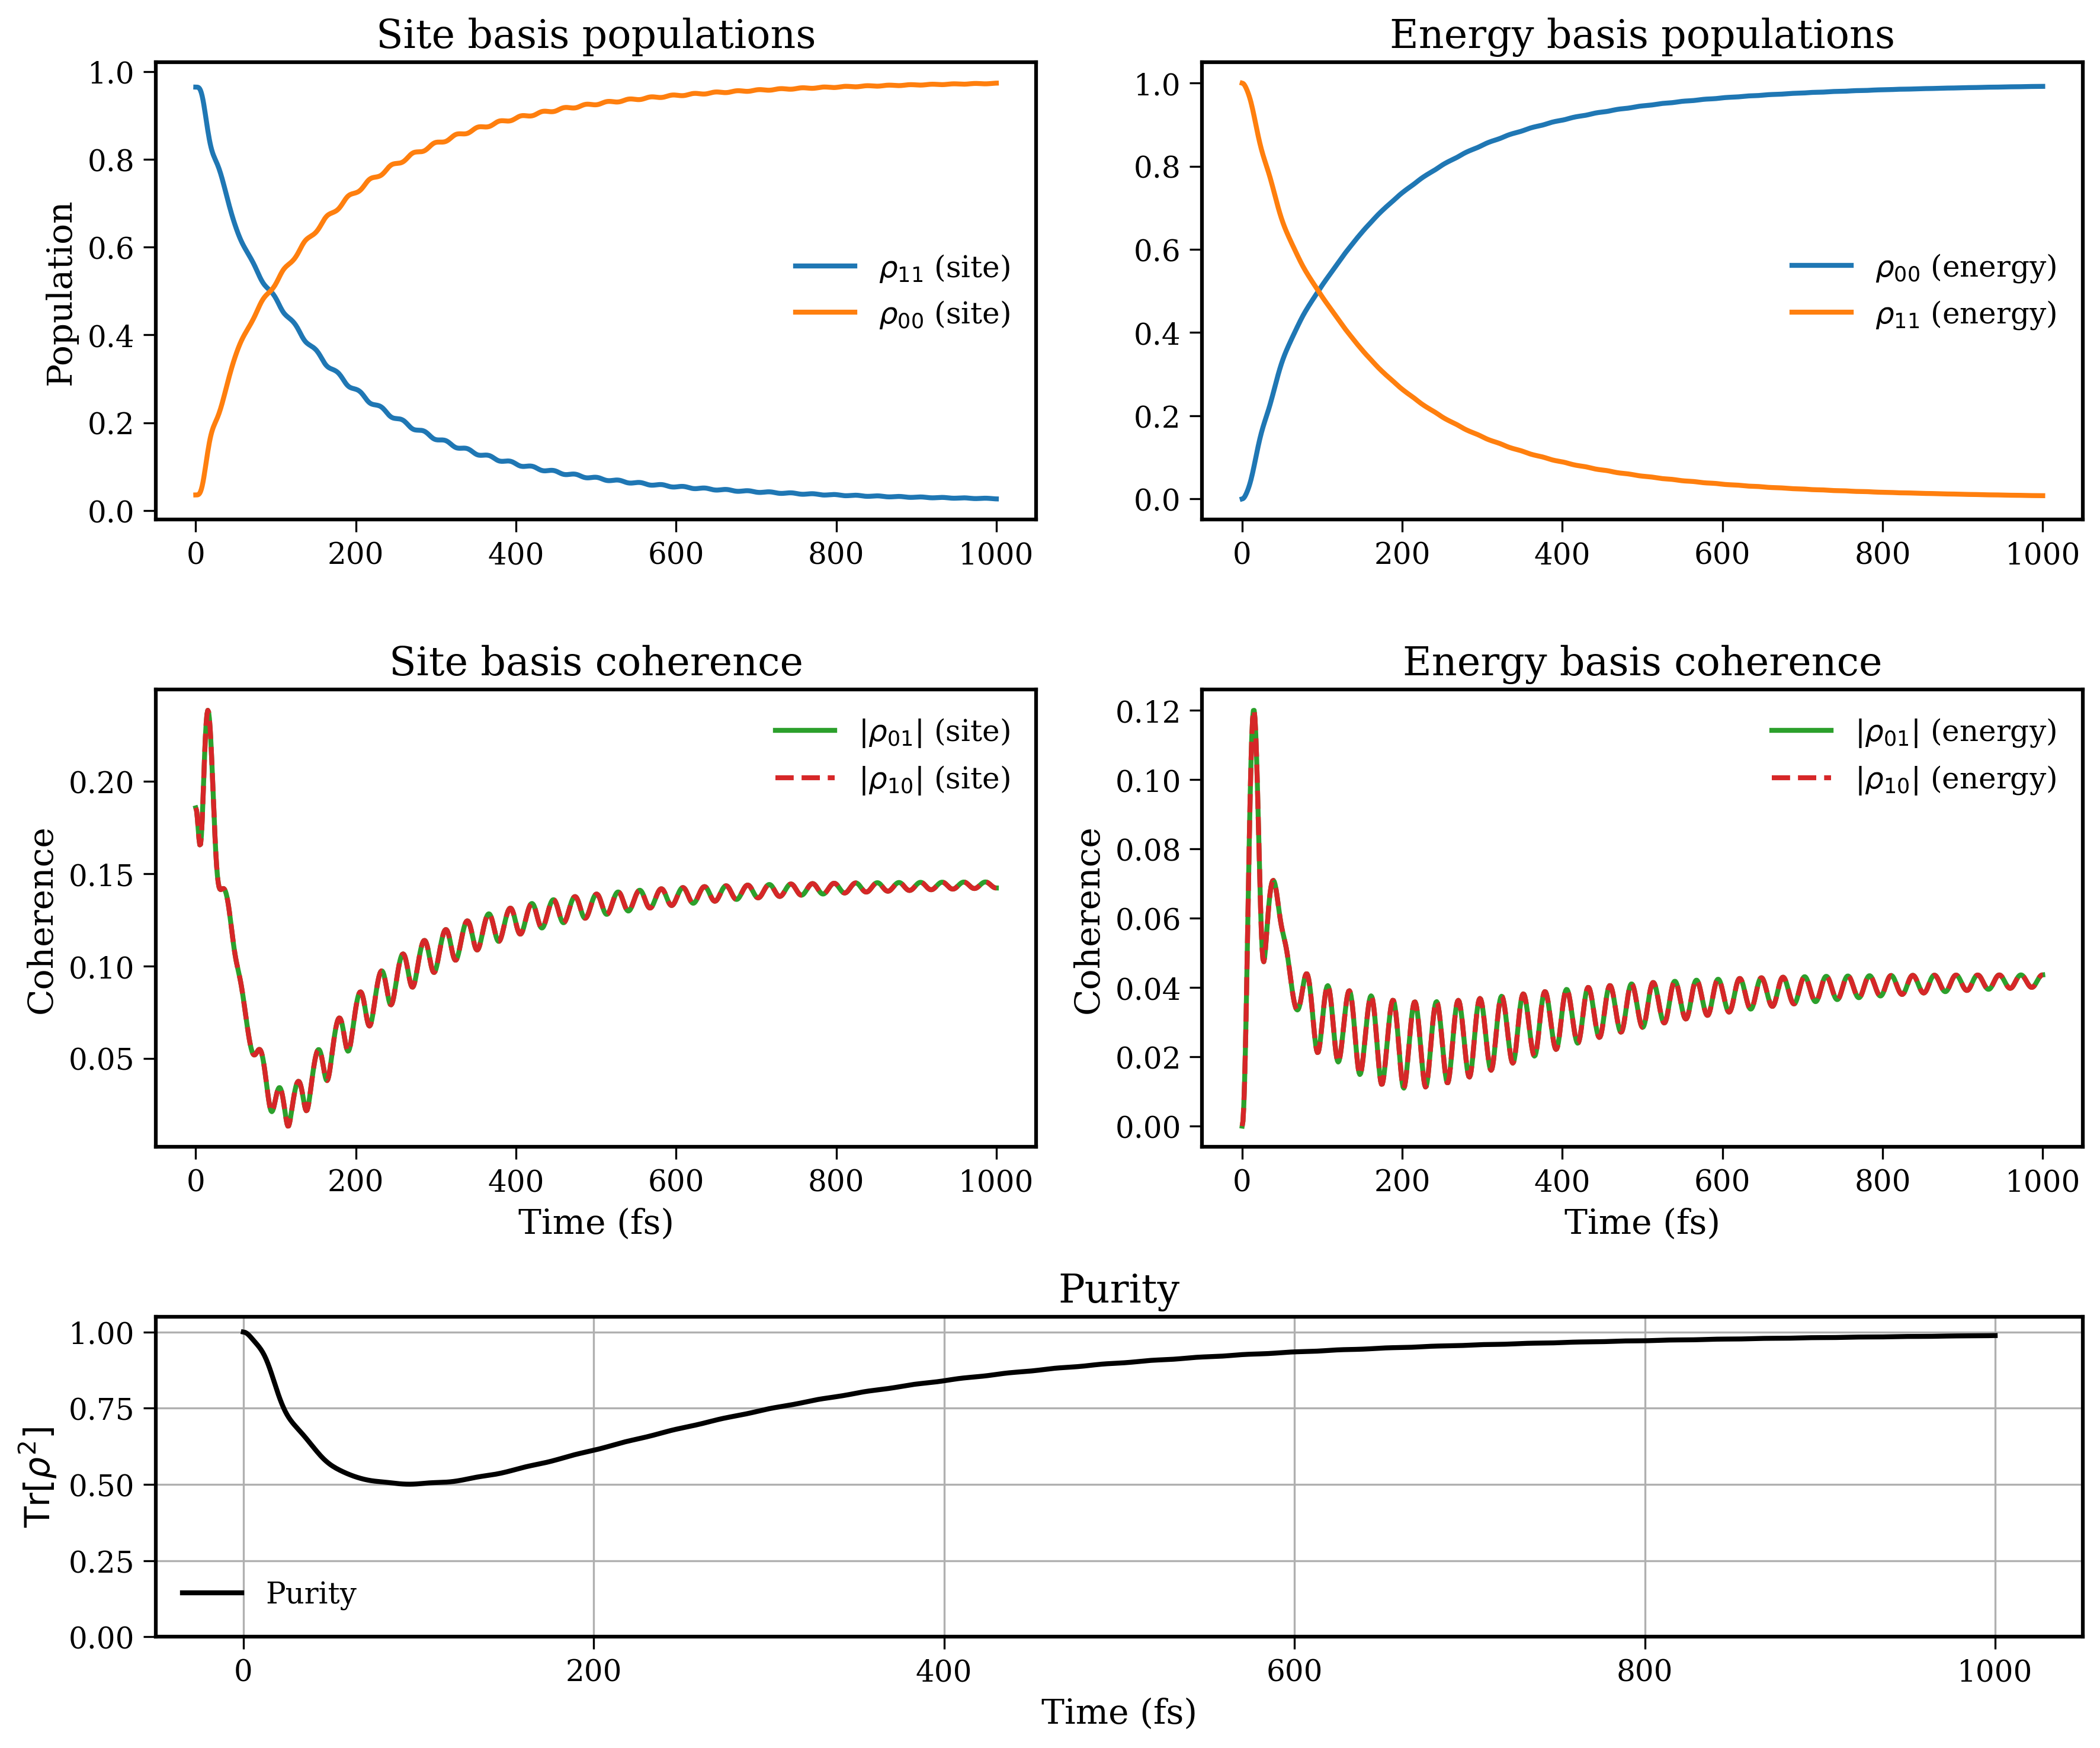

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'lines.linewidth': 2,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.fontsize': 12,
    'figure.dpi': 300,
})

filename = 'structured_result_300K.dat.log'
data = np.loadtxt(filename, delimiter=' ', dtype=complex)

t_fs = data[:, 0].real
pop_exc = data[:, 1].real
coh_01 = data[:, 2]
coh_10 = data[:, 3]
pop_gnd = data[:, 4].real

# Site basis Hamiltonian 
H = np.array([[1500/2, 600/2], [600/2, -1500/2]], dtype=np.complex128)
evals, U = np.linalg.eigh(H)
print(U.T.conj() @ H @ U)  

# Energy basis transformation and purity
pop_e0 = []
pop_e1 = []
coh_e01 = []
coh_e10 = []
purity = []

for p00, p11, p01, p10 in zip(pop_gnd, pop_exc, coh_01, coh_10):
    rho_site = np.array([[p11, p10], [p01, p00]], dtype=np.complex128)
    purity.append(np.real(np.trace(rho_site @ rho_site)))
    rho_e = U.conj().T @ rho_site @ U
    pop_e0.append(rho_e[0, 0].real)
    pop_e1.append(rho_e[1, 1].real)
    coh_e01.append(rho_e[0, 1])
    coh_e10.append(rho_e[1, 0])
pop_e0 = np.array(pop_e0)
pop_e1 = np.array(pop_e1)
coh_e01 = np.array(coh_e01)
coh_e10 = np.array(coh_e10)
purity = np.array(purity)

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.7])

# Panel 1: Populations in site basis
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t_fs, pop_exc, '-', color='C0', label=r'$\rho_{11}$ (site)')
ax1.plot(t_fs, pop_gnd, '-', color='C1', label=r'$\rho_{00}$ (site)')
ax1.set_ylabel('Population')
ax1.set_title('Site basis populations')
ax1.legend(frameon=False)
ax1.grid(False)

# Panel 2: Coherences in site basis
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(t_fs, np.abs(coh_01), '-', color='C2', label=r'$|\rho_{01}|$ (site)')
ax2.plot(t_fs, np.abs(coh_10), '--', color='C3', label=r'$|\rho_{10}|$ (site)')
ax2.set_xlabel('Time (fs)')
ax2.set_ylabel('Coherence')
ax2.set_title('Site basis coherence')
ax2.legend(frameon=False)
ax2.grid(False)

# Panel 3: Populations in energy basis
ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(t_fs, pop_e0, '-', color='C0', label=r'$\rho_{00}$ (energy)')
ax3.plot(t_fs, pop_e1, '-', color='C1', label=r'$\rho_{11}$ (energy)')
ax3.set_title('Energy basis populations')
ax3.legend(frameon=False)
ax3.grid(False)

# Panel 4: Coherences in energy basis
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t_fs, np.abs(coh_e01), '-', color='C2', label=r'$|\rho_{01}|$ (energy)')
ax4.plot(t_fs, np.abs(coh_e10), '--', color='C3', label=r'$|\rho_{10}|$ (energy)')
ax4.set_xlabel('Time (fs)')
ax4.set_ylabel('Coherence')
ax4.set_title('Energy basis coherence')
ax4.legend(frameon=False)
ax4.grid(False)

# Panel 5: Purity
ax5 = fig.add_subplot(gs[2, :])
ax5.plot(t_fs, purity, '-', color='k', label='Purity')
ax5.set_xlabel('Time (fs)')
ax5.set_ylabel(r'$\mathrm{Tr}[\rho^2]$')
ax5.set_title('Purity')
ax5.set_ylim(0, 1.05)
ax5.legend(frameon=False)
ax5.grid(True)

plt.tight_layout()
plt.savefig('combined_plot_site_energy_purity_structured.png', dpi=300, transparent=True)
plt.show()

